=================================================
### Práctica 5 — Detección y caracterización de caras
=================================================

##### Este cuaderno realiza:
1. Entrenamiento de un modelo de detección de expresiones faciales (disgusto, dolor, miedo, alegría).
2. Detección sobre video y filtro según expresión.
3. Filtro de payaso(?


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import cv2

In [48]:
# Cargar el modelo preentrenado
model = models.resnet18(pretrained=True)

# Obtener todas las capas del modelo
layers = list(model.children())

# Congelar todas las capas excepto las últimas 3 (ajustar requiere_grad)
for layer in layers[:-3]:  # Todas las capas excepto las últimas 3
    for param in layer.parameters():
        param.requires_grad = False

# Modificar la última capa (fully connected) para adaptarla a 4 clases
model.fc = nn.Linear(model.fc.in_features, 4)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Dispositivo de entrenamiento (GPU si está disponible, si no CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Entrenamiento
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    correct_predictions = 0  # Para contar las predicciones correctas
    total_predictions = 0
    model.train()  # Establecer el modelo en modo de entrenamiento
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Limpiamos los gradientes

        outputs = model(images)  # Pasamos las imágenes por la red
        loss = criterion(outputs, labels)  # Calculamos la pérdida

        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos

        running_loss += loss.item()

     # Calcular la precisión
        _, predicted = torch.max(outputs, 1)  # Obtener la clase predicha
        correct_predictions += (predicted == labels).sum().item()  # Comparar con etiquetas reales
        total_predictions += labels.size(0)  # Aumentar el total de predicciones

    accuracy = correct_predictions / total_predictions  # Calcular la precisión
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy * 100:.2f}%')

# Guardar el modelo entrenado
torch.save(model.state_dict(), "modelo_emociones.pth")
print("\nModelo guardado como modelo_emociones.pth")

C:\Users\lucia\Downloads\VC_P5\VC_P5\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lucia\Downloads\VC_P5\VC_P5\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 1.010001677274704, Accuracy: 61.68%
Epoch 2, Loss: 0.3571888208389282, Accuracy: 86.35%
Epoch 3, Loss: 0.16945361942052842, Accuracy: 93.91%
Epoch 4, Loss: 0.13243760392069817, Accuracy: 96.22%
Epoch 5, Loss: 0.07409076113253832, Accuracy: 97.53%

Modelo guardado como modelo_emociones.pth


In [49]:
correct = 0
total = 0
model.eval()  # Establecer el modelo en modo de evaluación

# Aquí usaríamos un conjunto de datos de prueba similar al de entrenamiento

with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the emotions test images: {100 * correct / total}%')

Accuracy of the model on the emotions test images: 73.37662337662337%


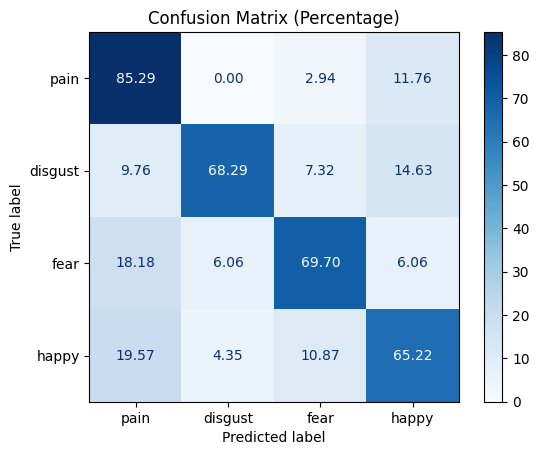

In [50]:
# Lista para almacenar las predicciones y etiquetas reales
all_preds = []
all_labels = []

# Evaluar el modelo
model.eval()  # Cambiar a modo de evaluación
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())  # Guardar predicciones
        all_labels.extend(labels.cpu().numpy())  # Guardar etiquetas reales

# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Convertir la matriz a porcentaje
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Mostrar la matriz de confusión
classes = emociones  # Etiquetas de las emociones
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=classes)
disp.plot(cmap='Blues', values_format=".2f")
plt.title("Confusion Matrix (Percentage)")
plt.show()

In [18]:
# Transformación de imagen
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 emociones
model.load_state_dict(torch.load("modelo_emociones.pth", map_location=device))
model.to(device)
model.eval()

emociones = ['pain', 'disgust', 'fear', 'happy']

# -------------------------
# Cargar filtros PNG
# -------------------------
filter_imgs = {
    'pain': cv2.imread(os.path.join(ruta_base, 'filters', 'pain.png'), cv2.IMREAD_UNCHANGED),
    'disgust': cv2.imread(os.path.join(ruta_base, 'filters', 'disgust.png'), cv2.IMREAD_UNCHANGED),
    'fear': cv2.imread(os.path.join(ruta_base, 'filters', 'fear.webp'), cv2.IMREAD_UNCHANGED),
    'happy': cv2.imread(os.path.join(ruta_base, 'filters', 'happy.png'), cv2.IMREAD_UNCHANGED)
}

# -------------------------
# Detector de caras
# -------------------------
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# -------------------------
# Función para overlay con alpha
# -------------------------
def overlay_image(face_roi, filter_img, region="full"):
    """
    Aplica un PNG con transparencia sobre la región de la cara.
    region: 'full', 'upper', 'middle', 'eyes', 'cheeks'
    """
    h, w = face_roi.shape[:2]

    if region == "upper":  # orejas
        fw, fh = w, h//2
        x_offset, y_offset = 0, 0
        filter_resized = cv2.resize(filter_img, (fw, fh))
        positions = [(x_offset, y_offset)]

    elif region == "middle":  # nariz/bigotes
        fw, fh = int(w*0.8), h//4
        x_offset = int(w*0.1)
        y_offset = int(h*0.52)  # bajar un poco respecto al centro
        filter_resized = cv2.resize(filter_img, (fw, fh))
        positions = [(x_offset, y_offset)]

    elif region == "eyes":  # ojos (repetir)
        fw, fh = int(w*0.3), h//5
        y_offset = h//4
        filter_resized = cv2.resize(filter_img, (fw, fh))
        # colocar en ambos ojos
        positions = [(w//8, y_offset), (w - w//8 - fw, y_offset)]

    else:  # full cara
        fw, fh = w, h
        x_offset, y_offset = 0, 0
        filter_resized = cv2.resize(filter_img, (fw, fh))
        positions = [(x_offset, y_offset)]

    # Aplicar overlay con alpha
    for x_off, y_off in positions:
        fh, fw = filter_resized.shape[:2]
        if filter_resized.shape[2] == 4:
            alpha = filter_resized[:, :, 3] / 255.0
            overlay_color = filter_resized[:, :, :3]
        else:
            alpha = np.ones((fh, fw))
            overlay_color = filter_resized

        for c in range(3):
            face_roi[y_off:y_off+fh, x_off:x_off+fw, c] = (
                alpha * overlay_color[:, :, c] +
                (1 - alpha) * face_roi[y_off:y_off+fh, x_off:x_off+fw, c]
            )

    return face_roi

# -------------------------
# Webcam
# -------------------------
cap = cv2.VideoCapture(0)
print("Iniciando webcam...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Recortar cara
        face = frame[y:y+h, x:x+w]

        # Convertir a PIL para el modelo
        face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        input_tensor = transform(face_pil).unsqueeze(0).to(device)

        # Predicción
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            emocion = emociones[pred.item()]

        # Aplicar filtro según emoción
        if emocion == "pain":
            face = overlay_image(face, filter_imgs['pain'], region="upper")
        elif emocion == "disgust":
            face = overlay_image(face, filter_imgs['disgust'], region="middle")
        elif emocion == "fear":
            face = overlay_image(face, filter_imgs['fear'], region="eyes")
        elif emocion == "happy":
            face = overlay_image(face, filter_imgs['happy'], region="middle")

        # Pegar cara de vuelta en frame
        frame[y:y+h, x:x+w] = face

        # Texto de emoción
        cv2.putText(frame, emocion.upper(), (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    cv2.imshow("Detector de emociones con filtros", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

C:\Users\lucia\AppData\Local\Temp\ipykernel_19796\3516352871.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("modelo_emociones.pth", ma

Iniciando webcam...
